[View in Colaboratory](https://colab.research.google.com/github/danielcanueto/misc/blob/master/spot_check_machine_learning_algorithms_in_python.ipynb)

In [0]:
# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [0]:

# load the dataset, returns X and y elements
def load_dataset():
	return make_classification(n_samples=1000, n_classes=2, random_state=1)

# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models

# no transforms pipeline
def pipeline_none(model):
	return model

# standardize transform pipeline
def pipeline_standardize(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# normalize transform pipeline
def pipeline_normalize(model):
	steps = list()
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# standardize and normalize pipeline
def pipeline_std_norm(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline

# evaluate a single model
def evaluate_model(X, y, model, folds, metric, pipe_func):
	# create the pipeline
	pipeline = pipe_func(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores

# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric, pipe_func):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric, pipe_func)
	except:
		scores = None
	return scores

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, pipe_funcs, folds=10, metric='accuracy'):
	results = dict()
	for name, model in models.items():
		# evaluate model under each preparation function
		for i in range(len(pipe_funcs)):
			# evaluate the model
			scores = robust_evaluate_model(X, y, model, folds, metric, pipe_funcs[i])
			# update name
			run_name = str(i) + name
			# show process
			if scores is not None:
				# store a result
				results[run_name] = scores
				mean_score, std_score = mean(scores), std(scores)
				print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
			else:
				print('>%s: error' % run_name)
	return results

# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')


Defined 53 models
>0logistic: 0.847 (+/-0.037)
>1logistic: 0.847 (+/-0.037)
>2logistic: 0.846 (+/-0.039)
>3logistic: 0.846 (+/-0.039)
>0ridge-0.1: 0.846 (+/-0.037)
>1ridge-0.1: 0.846 (+/-0.037)
>2ridge-0.1: 0.847 (+/-0.037)
>3ridge-0.1: 0.847 (+/-0.037)
>0ridge-0.2: 0.846 (+/-0.037)
>1ridge-0.2: 0.846 (+/-0.037)
>2ridge-0.2: 0.847 (+/-0.037)
>3ridge-0.2: 0.847 (+/-0.037)
>0ridge-0.3: 0.846 (+/-0.037)
>1ridge-0.3: 0.846 (+/-0.037)
>2ridge-0.3: 0.847 (+/-0.037)
>3ridge-0.3: 0.847 (+/-0.037)
>0ridge-0.4: 0.846 (+/-0.037)
>1ridge-0.4: 0.846 (+/-0.037)
>2ridge-0.4: 0.848 (+/-0.038)
>3ridge-0.4: 0.848 (+/-0.038)
>0ridge-0.5: 0.846 (+/-0.037)
>1ridge-0.5: 0.846 (+/-0.037)
>2ridge-0.5: 0.848 (+/-0.038)
>3ridge-0.5: 0.848 (+/-0.038)
>0ridge-0.6: 0.846 (+/-0.037)
>1ridge-0.6: 0.846 (+/-0.037)
>2ridge-0.6: 0.848 (+/-0.038)
>3ridge-0.6: 0.848 (+/-0.038)
>0ridge-0.7: 0.846 (+/-0.037)
>1ridge-0.7: 0.846 (+/-0.037)
>2ridge-0.7: 0.848 (+/-0.038)
>3ridge-0.7: 0.848 (+/-0.038)
>0ridge-0.8: 0.846 (+/-0.0

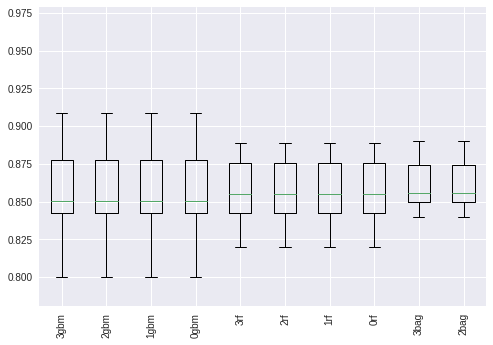

In [3]:

# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# define transform pipelines
pipelines = [pipeline_none, pipeline_standardize, pipeline_normalize, pipeline_std_norm]
# evaluate models
results = evaluate_models(X, y, models, pipelines)
# summarize results
summarize_results(results)